In [1]:
import pickle 
import os
import math
import spectools_ir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as AA

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import host_subplot
from spectools_ir.slabspec import make_spec
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from collections import OrderedDict

In [2]:
convol_fwhm = 30.
au=1.5e11
CO_model=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)
water_model=make_spec('H2O',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.45,convol_fwhm=convol_fwhm,d_pc=140.,res=1e-5) # play with convol_fwhm (broader for IQ tau?)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q1.txt


In [3]:
pathspec = '/Users/belaarwen/Desktop/Vassar/Coursework/Classes/Astronomy/Astronomy 300:301- Senior Thesis/NIRSPECdata'

names,labels,redshifts = np.loadtxt(pathspec+'/NIRSPECinfo_Needreview.csv',
                             usecols=[0,1,3],                    #identifies the column for name and the colume for redshift
                             delimiter=',',                      #file is a csv, so need to identify delimiter as a comma
                             dtype='str',                        
                             unpack=True,                        #so that we can unpack both names and redshifts at the same time
                             skiprows=1)                         #accounts for the headings row

spec_d = {}                                                      #creating a dictionary of spectra
for name in names:                                               #grabs only list of names from the csv
    f = os.path.join(pathspec,'nirspec_'+name+'_glue.dat')
    if os.path.isfile(f):
        wavelength, flux = np.loadtxt(f,skiprows=27,unpack=True) #read data from file
        data = [wavelength,flux]                                 #merge data
        spec_d[name] = data                                      #write to dictionary

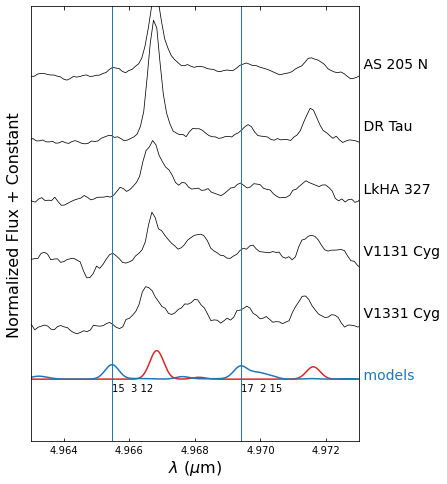

In [6]:
N = int(len(spec_d)/6)                                           #divide number of spectra by 6
N0 = len(spec_d)%6                                               #find number of remaining spectra
n = 0                                                            #to count through dictionary through mutliple loops

for i in range(N):                                               #create N figures
    fig = plt.figure(i+1,figsize=(20,8))                         #create the ith figure
    plt.rcParams['axes.labelsize'] = 16                          #set label fontsize
    gs = GridSpec(1,3)
    ax1 = host_subplot(gs[0, 0],axes_class=AA.Axes)
    lower_limit = 4.963;upper_limit = 4.973
    for j in range(6):                                           #plotting loop for the 6 spectra
        offset = (6 - j)*0.5                                     #setting position on graph
        spot = list(spec_d.items())[n]                           #calls the nth key of the dictionary
        name = spot[0]                                           #grabs the name from the dictionary "entry"
        wave,flux = spot[1]                                      #grabs the wavelength and flux
        fix_flux = flux[np.logical_not(np.isnan(flux))]          #remove fluxes
        avg_flux = np.average(fix_flux)                          #finds average flux value
        normflux = np.divide(flux,avg_flux)                      #normalizes flux so average flux  = 1
        sflux = normflux+offset                                  #offsets normalized flux
        redshift = np.float64(redshifts[n])                      #grabs the redshifts from the csv in the same order as plotted
        label = labels[n]
        ax1.plot(wave+redshift,sflux,'k',linewidth=.75);         #plots wave with redshift adjusted against normalized flux
        ax1.text(upper_limit,offset+1,' '+label,fontsize=14)      #put obj name in between subplots
        n+=1                                                     #next dictionary value
    
    #adding models to the bottom of the plots
    ax1.plot(CO_model['spectrum']['wave'], 0.5*CO_model['spectrum']['convolflux']+offset+0.5, label='Convolved CO Model Spectrum', color='C3')
    ax1.plot(water_model['spectrum']['wave'], 2*water_model['spectrum']['convolflux']+offset+0.5, label='Convolved H20 Model Spectrum', color='C0')   
    ax1.text(upper_limit,offset+0.5,' models',color='C0',fontsize=14)         #put obj name in next to the sub

    ax1.set_xlim(lower_limit, upper_limit);ax1.set_ylim(1,4.5);ax1.get_yaxis().set_ticks([])
    ax1.set_xlabel('$\lambda$ ($\mu$m)',fontsize=14);ax1.set_ylabel('Normalized Flux + Constant',fontsize=14)

#adding quantum numbers:  
    for i,lam in enumerate(water_model['lineparams']['wave']):
        if((lam>lower_limit) & (lam<upper_limit) & (water_model['lineparams']['eup_k'][i]>4000) & (water_model['lineparams']['tau_peak'][i]>0.15)):
            ax1.axvline(lam, linewidth=1, color='tab:blue')
            ax1.text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())
    
#in case of a remainder:
if N0 > 0:                                                       #create a final figure with any remaining spectra
    fig = plt.figure(N+1,figsize=(20,8))                         #create final figure
    plt.rcParams['axes.labelsize'] = 16                          #set label fontsize
    gs = GridSpec(1,3)
    ax1 = host_subplot(gs[0, 0],axes_class=AA.Axes)
    lower_limit = 4.963;upper_limit = 4.973
    for j in range(N0):                                          #add final spectra to fig
        offset = (6 - j)*0.5                                     #setting position on graph
        spot = list(spec_d.items())[n]                           #calls the nth key of the dictionary
        name = spot[0]                                           #grabs the name from the dictionary "entry"
        wave,flux = spot[1]                                      #grabs the wavelength and flux
        fix_flux = flux[np.logical_not(np.isnan(flux))]          #remove nan fluxes
        avg_flux = np.average(fix_flux)                          #finds average flux value
        normflux = np.divide(flux,avg_flux)                      #normalizes flux so average flux  = 1
        sflux = normflux+offset                                  #offsets normalized flux
        redshift = np.float64(redshifts[n])                      #grabs the redshifts from the csv in the same order as plotted
        label = labels[n]                                        #pulls the correctly formated names to plot
        ax1.plot(wave+redshift,sflux,'k',linewidth=.75);         #plots wave with redshift adjusted against normalized flux
        ax1.text(upper_limit,offset+1,' '+label,fontsize=14)     #put obj name in between subplots
        n+=1                                                     #next dictionary value
    
    #adding models to the bottom of final plot, offset to fall right below last spectra
    ax1.plot(CO_model['spectrum']['wave'], 0.5*CO_model['spectrum']['convolflux']+offset+0.5, label='Convolved CO Model Spectrum', color='C3')
    ax1.plot(water_model['spectrum']['wave'], 2*water_model['spectrum']['convolflux']+offset+0.5, label='Convolved H20 Model Spectrum', color='C0')   
    ax1.text(upper_limit,offset+0.5,' models',color='C0',fontsize=14)        #put obj name in between subplots

    ax1.set_xlim(lower_limit, upper_limit);ax1.set_ylim(1,4.5);ax1.get_yaxis().set_ticks([])
    ax1.set_xlabel('$\lambda$ ($\mu$m)');ax1.set_ylabel('Normalized Flux + Constant')
    
#adding quantum lines:
    for i,lam in enumerate(water_model['lineparams']['wave']):
        if((lam>lower_limit) & (lam<upper_limit) & (water_model['lineparams']['eup_k'][i]>4000) & (water_model['lineparams']['tau_peak'][i]>0.15)):
            ax1.axvline(lam, linewidth=1, color='tab:blue')
            ax1.text(water_model['lineparams']['wave'][i],1.4,water_model['lineparams']['Qpp_HITRAN'][i].strip())          